In [1]:
import numpy 
import tensorflow as tf
import pandas as pd 
from PIL import Image
import os 
import matplotlib.pyplot as plt
import random
import numpy as np
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
label_map = {
    0 : 'Cat',
    1 : 'Dog'
}

batch = 32
img_w = 180
img_h = 180

In [3]:
path = './PetImages'
import random
image_filenames = np.array(os.listdir(path),dtype=np.str_)
random.shuffle(image_filenames)

# Extract features from dataset

In [4]:
def extract_feature(image):
    label,filename ,ext= image.split('.')
    return int(label),f"{label}.{filename}.{ext}"


feature = np.array([extract_feature(img) for img in image_filenames])
df = pd.DataFrame(feature,columns=['Label','filename'])

In [5]:
df.head()

Label    filename
0     1  1.6753.jpg
1     1  1.7836.jpg
2     1  1.6487.jpg
3     1  1.5589.jpg
4     1  1.2961.jpg

# Plotting sample of data

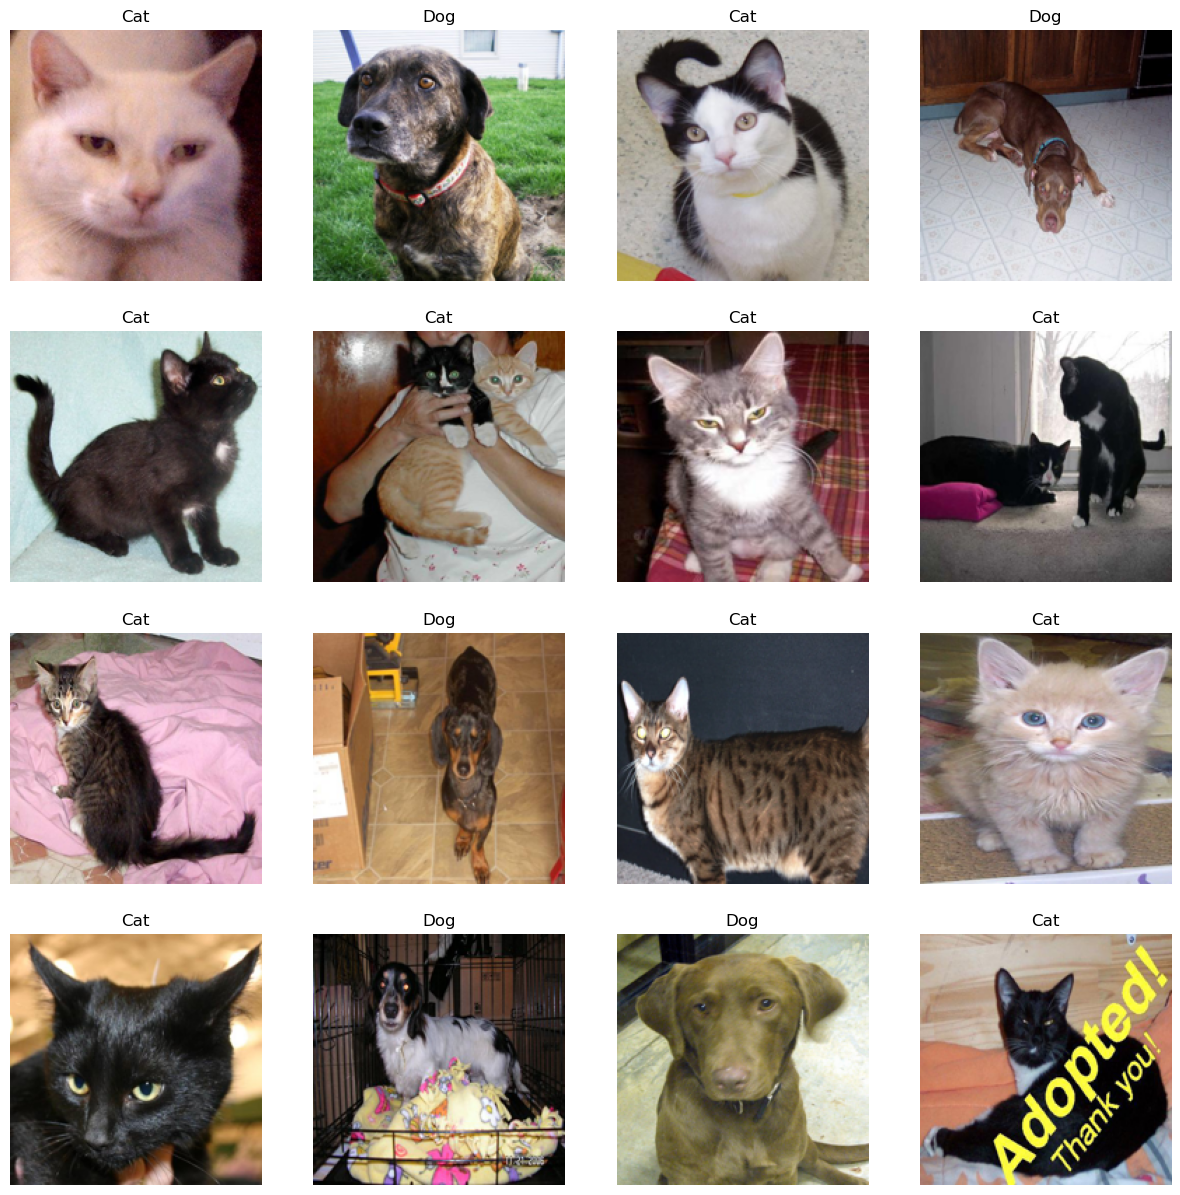

In [7]:
plt.figure(figsize=(15,15))

for i in range(16):
    rand = random.randint(0,len(df)-1)
    row = df.iloc[rand]
    ax = plt.subplot(4,4,i+1)
    img = Image.open(os.path.join(path,row.filename)).resize((180,180))
    plt.imshow(img)
    plt.title(label_map[int(row.Label)])
    plt.axis('off')

# Creating custom DataGenerator

In [8]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self,path,df,x_col,y_col,batch_size,img_size,shuffle=True):
        self.path = path
        self.df=df
        self.x_col=x_col
        self.y_col=y_col
        self.batch_size=batch_size
        self.img_size=img_size
        self.shuffle=shuffle
        
        self.n = len(self.df)
        
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
    def __get_input(self,x):
        img = Image.open(os.path.join(self.path,x))
        img = img.resize((self.img_size[0], self.img_size[1]))
        img = img.convert('L')
        return np.array(img,dtype=np.float32) / 255.
    
    def __get_data(self,batches):
        img_batch = batches[self.x_col]
        label_batch = batches[self.y_col]
        
        X = np.asarray([self.__get_input(x) for x in img_batch])
        y = np.asarray([int(y) for y in label_batch])
        
        return X,y
    
    def __getitem__(self,index):
        batches = self.df[index*self.batch_size:(index+1)*self.batch_size]
        X,y = self.__get_data(batches)
        return X,y

    def __len__(self):
        return self.n // self.batch_size

# Split between train, test and validation sets

In [31]:
from sklearn.model_selection import train_test_split

df_train,df_val = train_test_split(df,test_size=0.2,random_state=42)
df_train,df_test = train_test_split(df_train,test_size=0.1,random_state=42)


In [10]:
train_ds = CustomDataGenerator(path=path,
                               df=df_train,
                               x_col='filename',
                               y_col='Label',
                               batch_size=batch,
                               img_size=(img_w,img_h,1)
)

val_ds = CustomDataGenerator(path=path,
                               df=df_val,
                               x_col='filename',
                               y_col='Label',
                               batch_size=batch,
                               img_size=(img_w,img_h,1)
)

# 

In [11]:
checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# 

# First simple model

# Model

In [66]:
model= tf.keras.models.Sequential([
    Input((img_w,img_w,1)),
    Conv2D(16, (3,3) , activation='relu' ),
    MaxPooling2D(),
    Conv2D(32, (3,3) , activation='relu'),
    MaxPooling2D(),
    Conv2D(64 , (3,3) , activation='relu'),
    Flatten(),
    Dropout(0.3),
    
    Dense(256, activation = 'relu'),
    Dense(1)
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [67]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 178, 178, 16)      160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 41, 41, 64)        18496     
                                                                 
 flatten_3 (Flatten)         (None, 107584)           

In [68]:
epochs = 10

history = model.fit(train_ds,
                     epochs=epochs,
                     validation_data=val_ds,
                     callbacks=[checkpoint_callback],
                     )

Epoch 1/10
215/562 [==========>...................] - ETA: 1:37 - loss: 0.6944 - accuracy: 0.5257

c:\Users\janma\.conda\envs\catvsdog\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


562/562 [==============================] - ETA: 0s - loss: 0.6352 - accuracy: 0.6035
Epoch 1: val_loss improved from inf to 0.58437, saving model to best_model.h5
562/562 [==============================] - 186s 329ms/step - loss: 0.6352 - accuracy: 0.6035 - val_loss: 0.5844 - val_accuracy: 0.7001
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.4971 - accuracy: 0.7435
Epoch 2: val_loss improved from 0.58437 to 0.49292, saving model to best_model.h5
562/562 [==============================] - 187s 333ms/step - loss: 0.4971 - accuracy: 0.7435 - val_loss: 0.4929 - val_accuracy: 0.7574
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 0.4040 - accuracy: 0.8029
Epoch 3: val_loss improved from 0.49292 to 0.48089, saving model to best_model.h5
562/562 [==============================] - 203s 362ms/step - loss: 0.4040 - accuracy: 0.8029 - val_loss: 0.4809 - val_accuracy: 0.7376
Epoch 4/10
562/562 [==============================] - ETA: 0s - loss: 0.2905

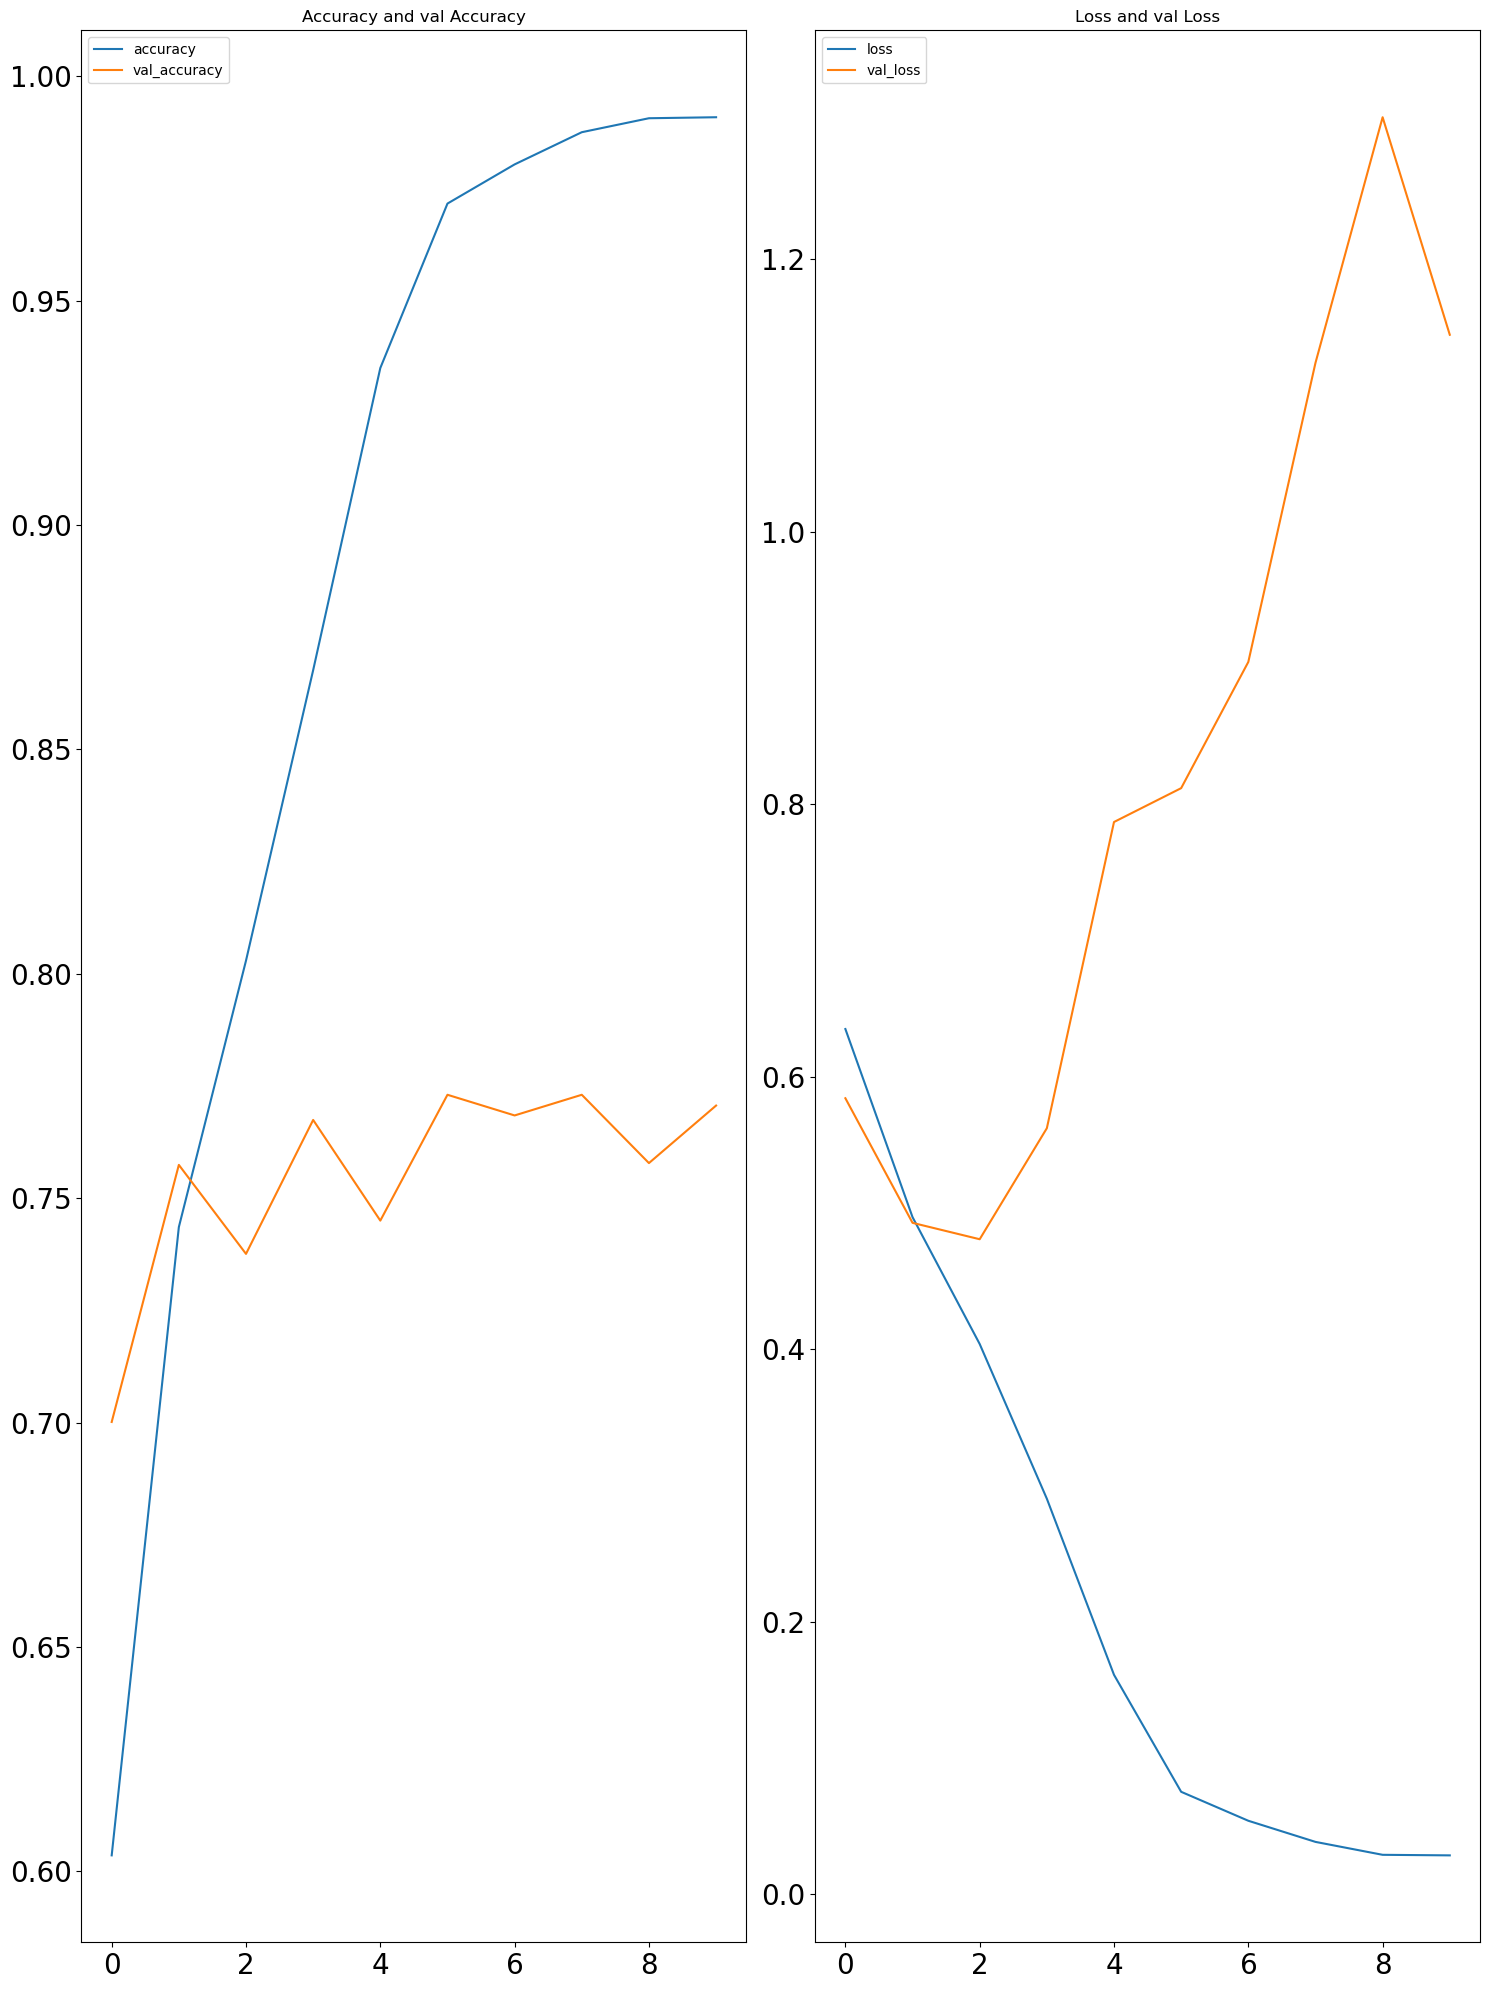

In [91]:
fig, axs = plt.subplots(1,2, figsize=(15,20))
epochs_range = range(epochs)

axs[0].plot(epochs_range,history.history['accuracy'],label='accuracy')
axs[0].plot(epochs_range,history.history['val_accuracy'],label='val_accuracy')
axs[0].set_title("Accuracy and val Accuracy")
axs[0].legend(loc='upper left')
axs[0].tick_params(axis='both', which='major', labelsize=20)

axs[1].plot(epochs_range,history.history['loss'],label='loss')
axs[1].plot(epochs_range,history.history['val_loss'],label='val_loss')
axs[1].set_title("Loss and val Loss")
axs[1].legend(loc='upper left')
axs[1].tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.show()
    

# Adding data augmentnation to prevent overfitting 

In [12]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_h,
                                  img_w,
                                  1)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [13]:
checkpoint_callback_aug = ModelCheckpoint(filepath='best_model_aug.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Model with data augmentation

In [21]:
model_aug= tf.keras.models.Sequential([
    data_augmentation,
    Conv2D(16, (3,3) , activation='relu' ),
    MaxPooling2D(),
    Conv2D(32, (3,3) , activation='relu'),
    MaxPooling2D(),
    Conv2D(64 , (3,3) , activation='relu'),
    MaxPooling2D(),
    Conv2D(96 , (3,3) , activation='relu'),
    MaxPooling2D(),
    Conv2D(128 , (3,3) , activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    Dropout(0.3),
    
    Dense(256, activation = 'relu'),
    Dense(1)
])

model_aug.compile(optimizer = 'adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [22]:
model_aug.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 1)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 178, 178, 16)      160       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 41, 41, 64)       

In [23]:
epochs = 20

history_aug = model_aug.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        callbacks=[checkpoint_callback_aug]
                        )

Epoch 1/20
562/562 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5009
Epoch 1: val_loss did not improve from 0.23647
562/562 [==============================] - 156s 269ms/step - loss: 0.6920 - accuracy: 0.5009 - val_loss: 0.6871 - val_accuracy: 0.4900
Epoch 2/20
562/562 [==============================] - ETA: 0s - loss: 0.6760 - accuracy: 0.5270
Epoch 2: val_loss did not improve from 0.23647
562/562 [==============================] - 140s 249ms/step - loss: 0.6760 - accuracy: 0.5270 - val_loss: 0.6440 - val_accuracy: 0.5825
Epoch 3/20
562/562 [==============================] - ETA: 0s - loss: 0.6298 - accuracy: 0.6148
Epoch 3: val_loss did not improve from 0.23647
562/562 [==============================] - 150s 267ms/step - loss: 0.6298 - accuracy: 0.6148 - val_loss: 0.5992 - val_accuracy: 0.7005
Epoch 4/20
562/562 [==============================] - ETA: 0s - loss: 0.5742 - accuracy: 0.6789
Epoch 4: val_loss did not improve from 0.23647
562/562 [==============

# Ploting the results

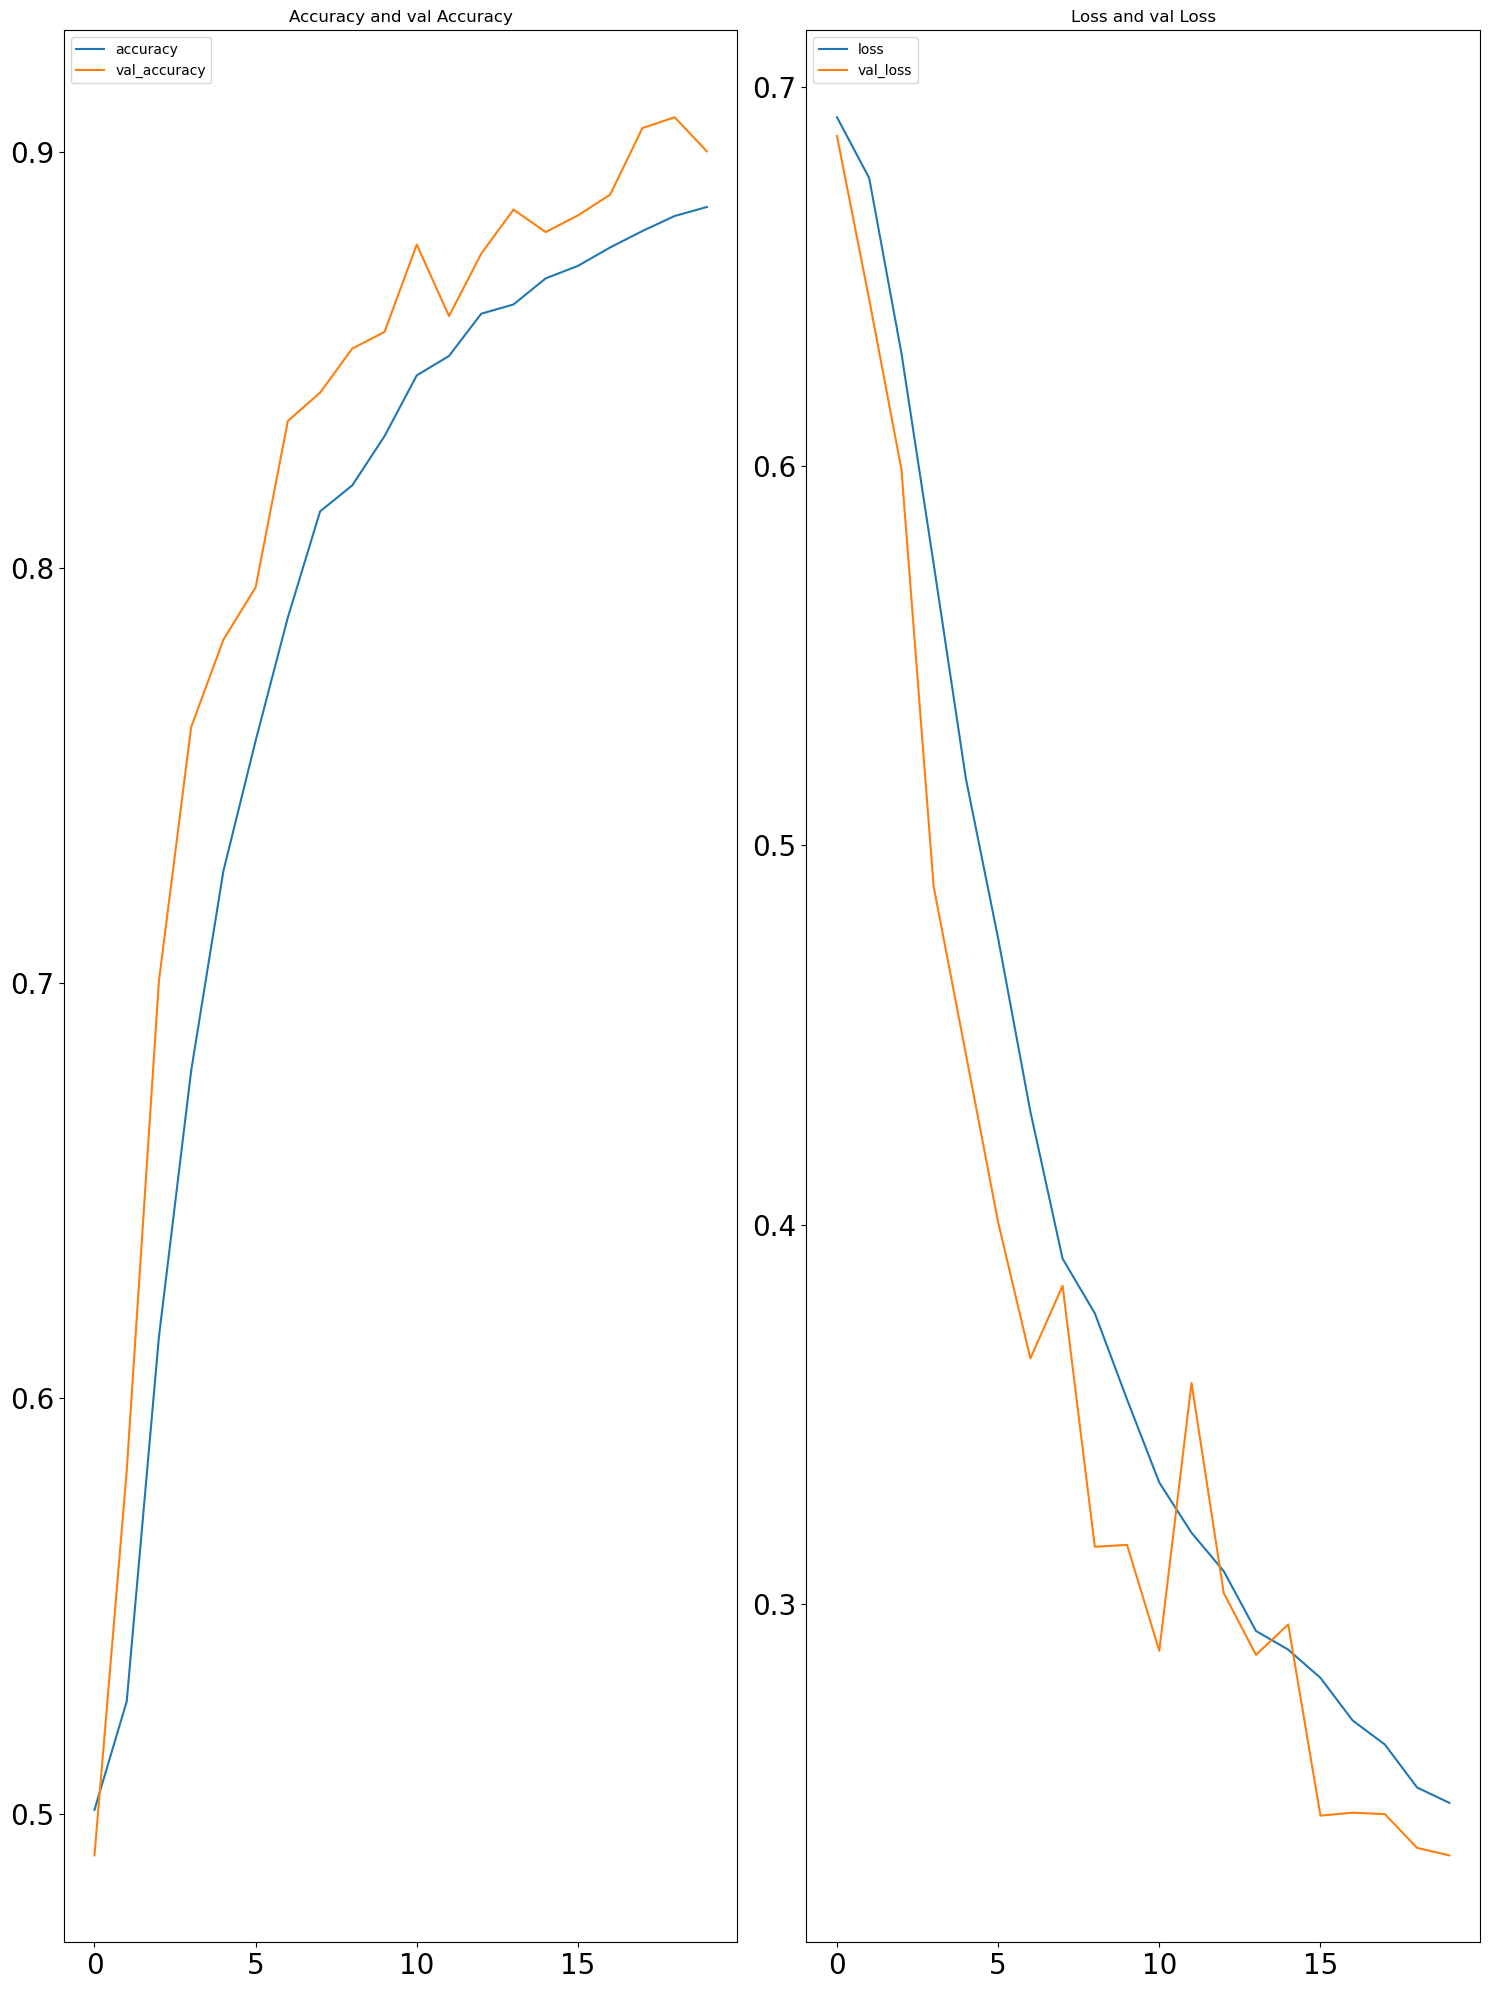

In [24]:
fig, axs = plt.subplots(1,2, figsize=(15,20))
epochs_range = range(epochs)

axs[0].plot(epochs_range,history_aug.history['accuracy'],label='accuracy')
axs[0].plot(epochs_range,history_aug.history['val_accuracy'],label='val_accuracy')
axs[0].set_title("Accuracy and val Accuracy")
axs[0].legend(loc='upper left')
axs[0].tick_params(axis='both', which='major', labelsize=20)

axs[1].plot(epochs_range,history_aug.history['loss'],label='loss')
axs[1].plot(epochs_range,history_aug.history['val_loss'],label='val_loss')
axs[1].set_title("Loss and val Loss")
axs[1].legend(loc='upper left')
axs[1].tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.show()
    

In [27]:
def predict(img):
    img_a = img.convert('L')
    img_a = np.asarray([img_a]) / 255.
    pred = model_aug.predict(img_a)
    pred_sig = tf.nn.sigmoid(pred)
    return pred_sig

# Predicted outcomes

1/1 [==============================] - 0s 24ms/step


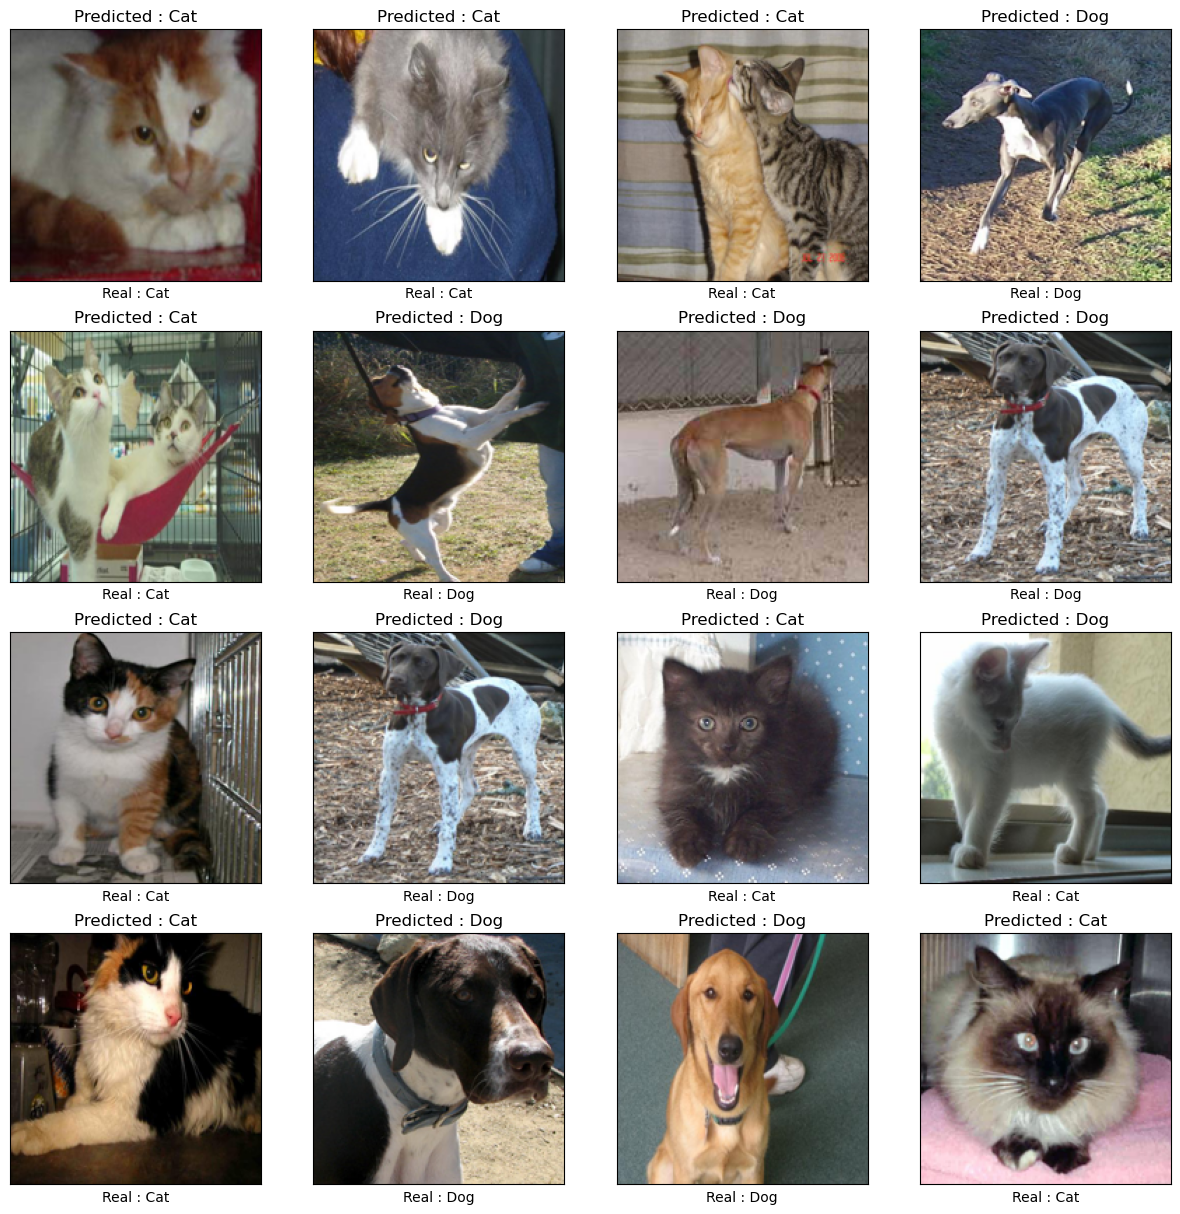

In [29]:
plt.figure(figsize=(15,15))

for i in range(16):
    rand = random.randint(0,len(df_test))
    row = df_test.iloc[rand]
    ax = plt.subplot(4,4,i+1)
    img = Image.open(os.path.join(path,row.filename)).resize((180,180))
    plt.imshow(img)
    label = predict(img) > 0.5
    plt.title(f"Predicted : {label_map[int(label)]}")
    plt.xlabel(f"Real : {label_map[int(row.Label)]}" )
    plt.xticks([])
    plt.yticks([])